In [1]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np


import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Using TensorFlow backend.


In [2]:
#label dictionary
label_dict = {0: 'tshirt',
              1: 'trouser',
              2: 'pullover',
              3: 'dress',
              4: 'coat',
              5: 'sandal',
              6: 'shirt',
              7: 'sneaker',
              8: 'bag',
              9: 'boot'}

In [3]:
#input dimensions
input_rows = 28
input_cols = 28
input_channels = 1

# Loading the FASHION-MNIST Data

In [4]:
#load the data with the format needed in the AC-GAN implementation
def load_fashion_mnist(input_rows, input_cols, path='fashionmnist/fashion-mnist_train.csv'):
    #read the csv data
    df = pd.read_csv(path)
    #extract the image pixels
    X_train = df.drop(columns = ['label'])
    X_train = X_train.as_matrix()
    X_train = X_train.reshape(X_train.shape[0], input_rows, input_cols)
    #extract the labels
    y_train = df['label'].as_matrix()
    
    return X_train, y_train

In [5]:
X_train, y_train = load_fashion_mnist(input_rows, input_cols)


/home/costa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys
/home/costa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [6]:
X_train.shape, y_train.shape, type(X_train), type(y_train)

((60000, 28, 28), (60000,), numpy.ndarray, numpy.ndarray)

## Designing an Auxillary Classifier GAN(AC-GAN)

In [7]:
class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        # Input shape
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Building and compiling the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Building the generator
        self.generator = self.build_generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extracting feature representation
        features = model(img)

        # Determining validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, X_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()
        #X_train, y_train = self.X_train, self.y_train

        # Configure inputs
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            gen_imgs = self.generator.predict([noise, sampled_labels])

            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

        return g_loss_epochs, d_loss_epochs
 

    def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("%d.png" % epoch)
        else:
            #plt.figure(figsize=fig_size)
            plt.show()
        plt.close()

    def sample_single_image(self, noise, label):
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

    def save_model(self):

        def save(model, model_name):
            model_path = "%s.json" % model_name
            weights_path = "%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            #
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [8]:
input_classes = pd.Series(y_train).nunique()
fashion_acgan = ACGAN(input_rows, input_cols, input_channels, input_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
__________

/home/costa/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 [D loss: 3.298151, acc.: 47.00%, op_acc: 7.00%] [G loss: 3.107574]


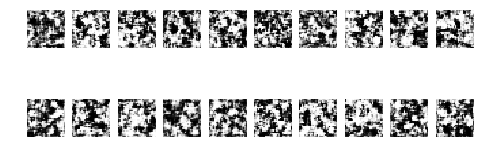

Epoch: 100 [D loss: 1.693387, acc.: 55.00%, op_acc: 67.00%] [G loss: 5.728377]


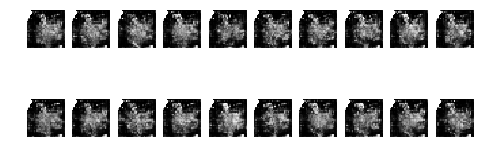

Epoch: 200 [D loss: 1.592885, acc.: 59.00%, op_acc: 68.00%] [G loss: 4.353864]


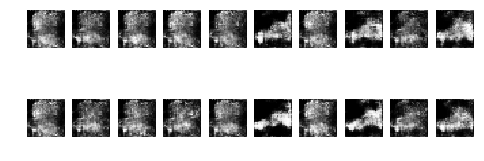

Epoch: 300 [D loss: 1.655417, acc.: 68.00%, op_acc: 62.00%] [G loss: 3.885315]


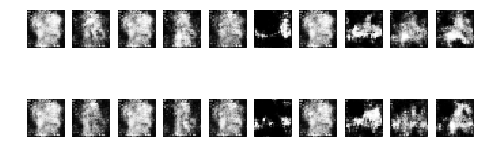

Epoch: 400 [D loss: 1.590490, acc.: 52.00%, op_acc: 63.00%] [G loss: 2.600957]


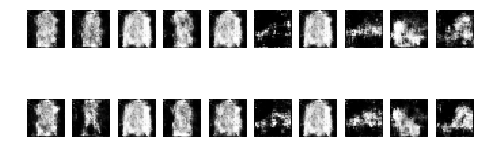

Epoch: 500 [D loss: 1.842119, acc.: 60.00%, op_acc: 55.00%] [G loss: 2.478105]


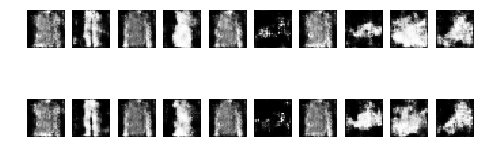

Epoch: 600 [D loss: 1.941881, acc.: 51.00%, op_acc: 46.00%] [G loss: 2.237965]


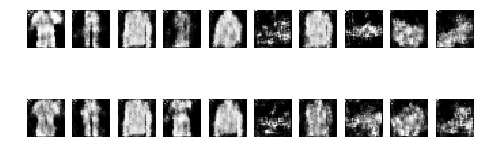

Epoch: 700 [D loss: 1.919250, acc.: 53.00%, op_acc: 45.00%] [G loss: 2.138456]


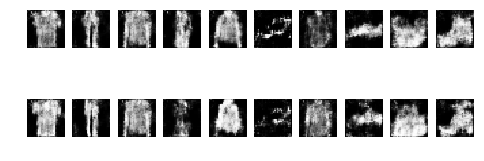

Epoch: 800 [D loss: 1.837498, acc.: 51.00%, op_acc: 50.00%] [G loss: 2.059625]


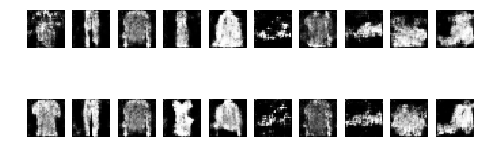

Epoch: 900 [D loss: 1.907127, acc.: 49.00%, op_acc: 45.00%] [G loss: 1.858281]


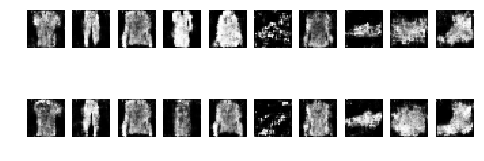

Epoch: 1000 [D loss: 1.799184, acc.: 52.00%, op_acc: 45.00%] [G loss: 2.121155]


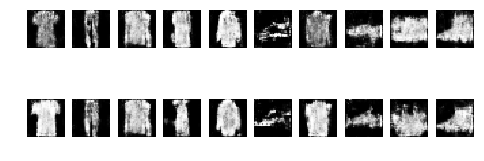

Epoch: 1100 [D loss: 1.925197, acc.: 44.00%, op_acc: 37.00%] [G loss: 1.880352]


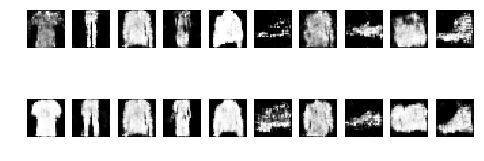

Epoch: 1200 [D loss: 1.775395, acc.: 56.00%, op_acc: 42.00%] [G loss: 2.213410]


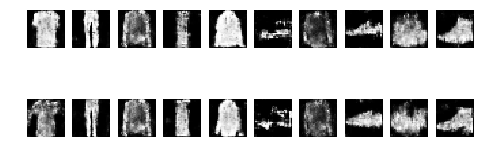

Epoch: 1300 [D loss: 1.911479, acc.: 42.00%, op_acc: 42.00%] [G loss: 1.809078]


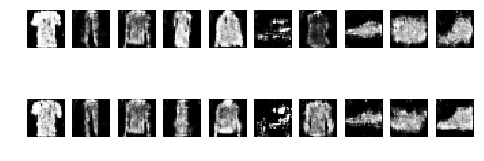

Epoch: 1400 [D loss: 1.848508, acc.: 48.00%, op_acc: 42.00%] [G loss: 1.764780]


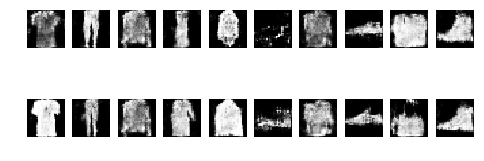

Epoch: 1500 [D loss: 1.654595, acc.: 51.00%, op_acc: 49.00%] [G loss: 1.795821]


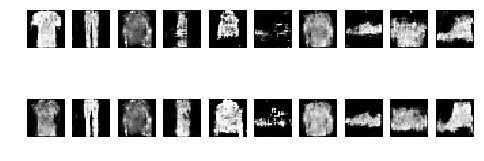

Epoch: 1600 [D loss: 1.797558, acc.: 51.00%, op_acc: 40.00%] [G loss: 1.970861]


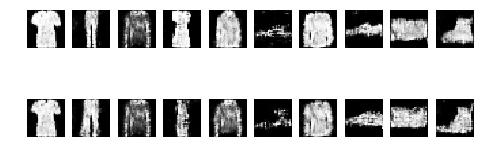

Epoch: 1700 [D loss: 1.806985, acc.: 54.00%, op_acc: 40.00%] [G loss: 1.935015]


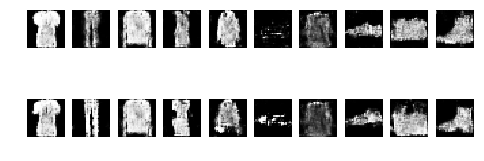

Epoch: 1800 [D loss: 1.811476, acc.: 46.00%, op_acc: 42.00%] [G loss: 1.843171]


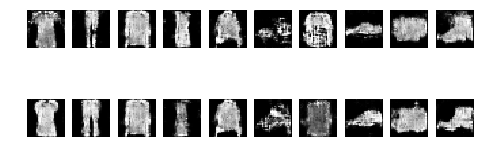

Epoch: 1900 [D loss: 1.703290, acc.: 47.00%, op_acc: 46.00%] [G loss: 1.669633]


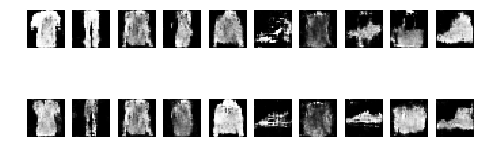

Epoch: 2000 [D loss: 1.808408, acc.: 44.00%, op_acc: 44.00%] [G loss: 1.921462]


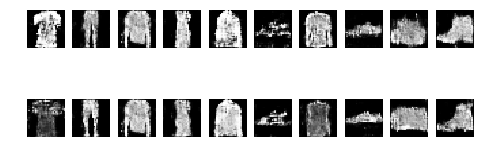

Epoch: 2100 [D loss: 1.833326, acc.: 46.00%, op_acc: 38.00%] [G loss: 1.851546]


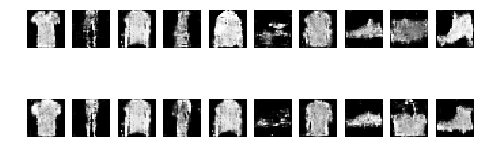

Epoch: 2200 [D loss: 1.822870, acc.: 47.00%, op_acc: 46.00%] [G loss: 1.781784]


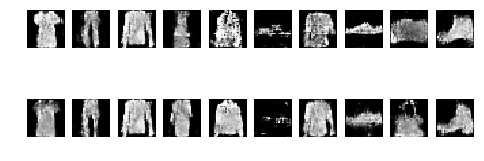

Epoch: 2300 [D loss: 1.782539, acc.: 50.00%, op_acc: 37.00%] [G loss: 1.737915]


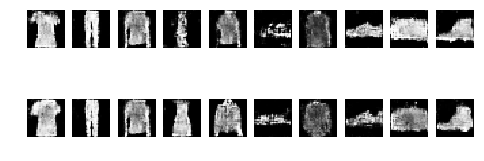

Epoch: 2400 [D loss: 1.698152, acc.: 61.00%, op_acc: 49.00%] [G loss: 1.808374]


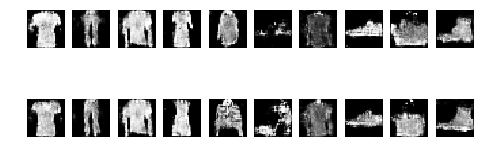

Epoch: 2500 [D loss: 1.857067, acc.: 55.00%, op_acc: 47.00%] [G loss: 1.767710]


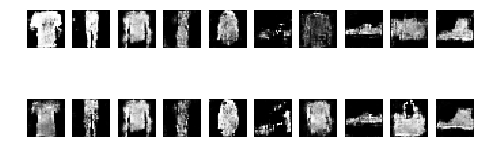

Epoch: 2600 [D loss: 1.751461, acc.: 46.00%, op_acc: 45.00%] [G loss: 1.921560]


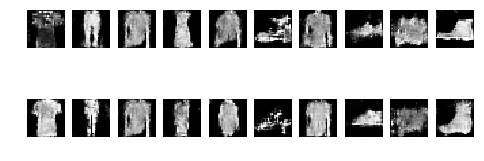

Epoch: 2700 [D loss: 1.629460, acc.: 50.00%, op_acc: 52.00%] [G loss: 1.712879]


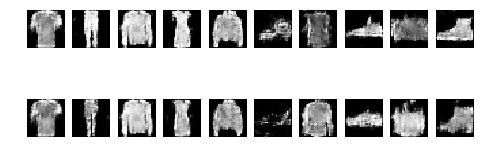

Epoch: 2800 [D loss: 1.736839, acc.: 45.00%, op_acc: 45.00%] [G loss: 1.798246]


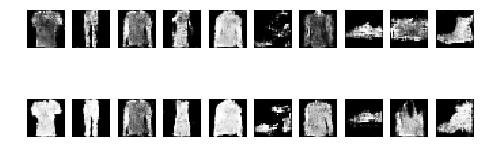

Epoch: 2900 [D loss: 1.659767, acc.: 55.00%, op_acc: 41.00%] [G loss: 1.834224]


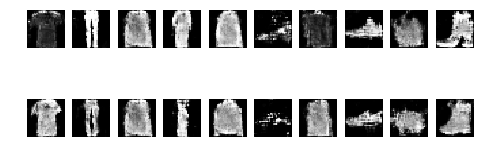

Epoch: 3000 [D loss: 1.851141, acc.: 51.00%, op_acc: 40.00%] [G loss: 1.672606]


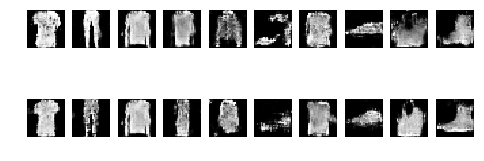

Epoch: 3100 [D loss: 1.683706, acc.: 58.00%, op_acc: 48.00%] [G loss: 1.802329]


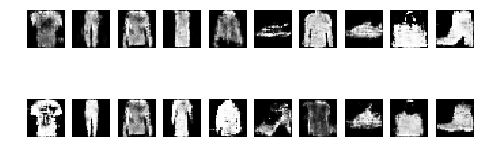

Epoch: 3200 [D loss: 1.734753, acc.: 48.00%, op_acc: 44.00%] [G loss: 1.689523]


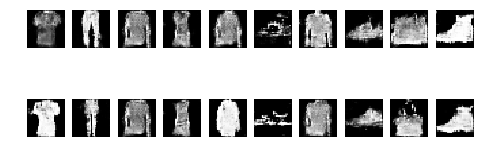

Epoch: 3300 [D loss: 1.789527, acc.: 52.00%, op_acc: 40.00%] [G loss: 1.800009]


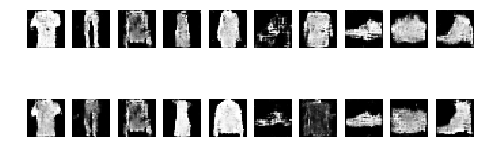

Epoch: 3400 [D loss: 1.704637, acc.: 52.00%, op_acc: 42.00%] [G loss: 1.738807]


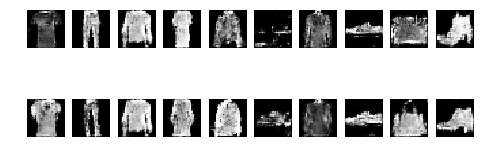

Epoch: 3500 [D loss: 1.789272, acc.: 51.00%, op_acc: 47.00%] [G loss: 1.726239]


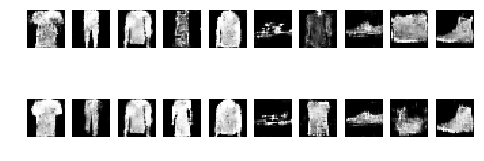

Epoch: 3600 [D loss: 1.642268, acc.: 53.00%, op_acc: 52.00%] [G loss: 1.705570]


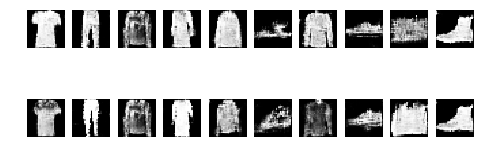

Epoch: 3700 [D loss: 1.730300, acc.: 46.00%, op_acc: 52.00%] [G loss: 1.688575]


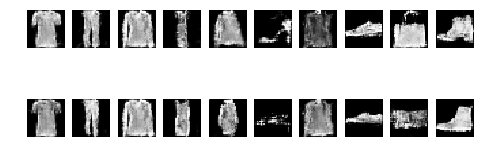

Epoch: 3800 [D loss: 1.656026, acc.: 52.00%, op_acc: 46.00%] [G loss: 1.772211]


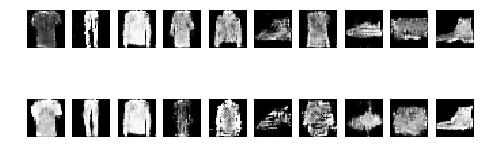

Epoch: 3900 [D loss: 1.727843, acc.: 53.00%, op_acc: 45.00%] [G loss: 1.912433]


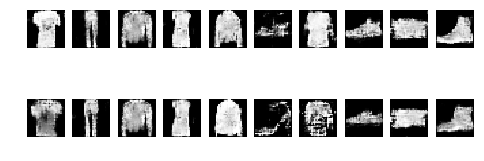

In [9]:
#Training the AC-GAN 
g_loss, d_loss = fashion_acgan.train(X_train, y_train, epochs=4000, batch_size=50, sample_interval=100)

 ## Sample Images Generated

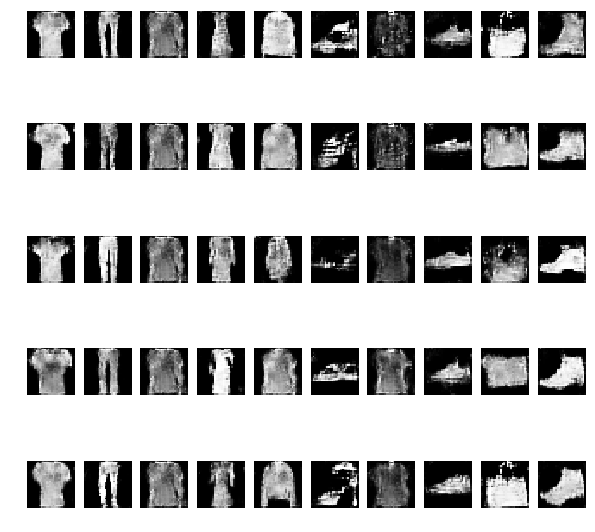

In [11]:
fashion_acgan.sample_images(0, smp_rows=5, smp_cols=10, save_img=False, fig_size=(10, 10))